In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt
from scipy import stats
from pandas_datareader import data as web
import numpy_financial as npf

In [2]:
def fetch_data(ticker, start_date, end_date):
    data = web.DataReader(ticker, data_source='yahoo', start=start_date, end=end_date)['Close']
    return data

In [3]:
def calculate_daily_returns(data):
    daily_returns = data.pct_change().dropna()
    return daily_returns

In [4]:
def calculate_portfolio_value(data, weights, investment_amount):
    norm_weights = weights / np.sum(weights)
    num_shares = (investment_amount * norm_weights) / data.iloc[0]
    portfolio_value = np.sum(num_shares * data, axis=1)
    return portfolio_value

In [5]:
def calculate_sharpe(daily_returns, risk_free_rate=0.02):
    sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    return sharpe

In [6]:
def calculate_xirr(portfolio_value):
    # XIRR = (final value of investment / initial investment)^(1 / number of years) - 1
    initial_investment = portfolio_value.iloc[0]
    final_investment = portfolio_value.iloc[-1]
    num_years = (portfolio_value.index[-1] - portfolio_value.index[0]).days / 365
    xirr = (final_investment / initial_investment) ** (1 / num_years) - 1
    return xirr

In [7]:
def calculate_volatility(daily_returns):
    volatility = daily_returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year
    return volatility

Portfolio Weights:
ADANIENT.NS      0.690106
TATASTEEL.NS     0.064352
ONGC.NS          0.016295
HINDALCO.NS      0.028782
NTPC.NS          0.023765
LT.NS            0.028910
TCS.NS           0.042990
COALINDIA.NS     0.021787
BHARTIARTL.NS    0.027301
WIPRO.NS         0.026979
CIPLA.NS         0.028733
dtype: float64

Portfolio Sharpe Ratio :  1.8231012274437144
Portfolio Volatility   :  0.4373150765670085
Portfolio XIRR%        :  98.65465910575423


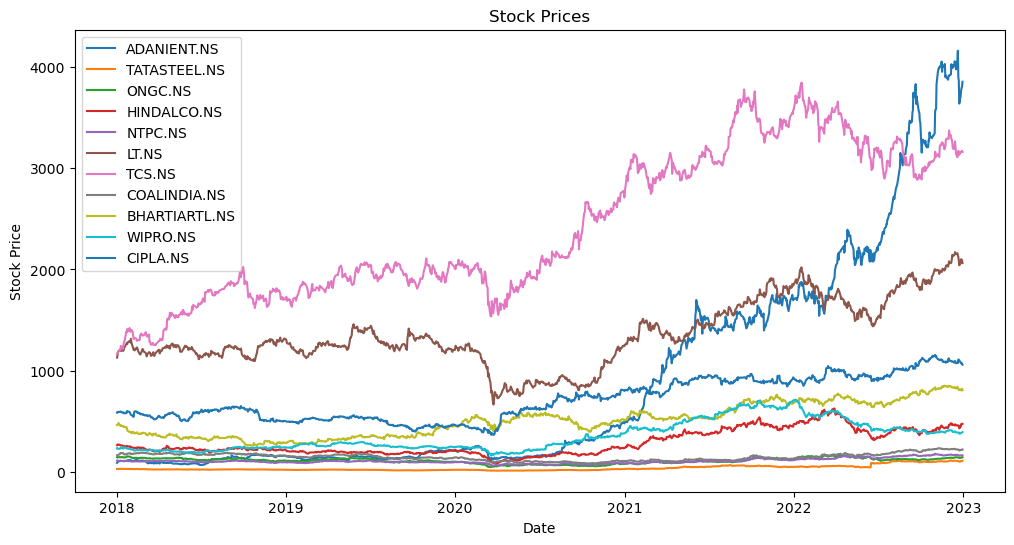

In [10]:
if __name__ == "__main__":
    # Input variables
    tickers = ['ADANIENT.NS', 'TATASTEEL.NS', 'ONGC.NS', 'HINDALCO.NS', 'NTPC.NS', 'LT.NS', 'TCS.NS', 'COALINDIA.NS', 'BHARTIARTL.NS', 'WIPRO.NS', 'CIPLA.NS']  # Replace with a list of desired stock symbols
    start_date = '2018-01-01'  # Replace with your desired start date: yyyy-mm-dd
    end_date = '2023-01-01'  # Replace with your desired end date: yyyy-mm-dd
    investment_amount = 1000000  # Replace with your desired investment amount

    # Fetch stock data for each stock
    stock_data_list = [yf.Ticker(ticker).history(start=start_date, end=end_date)['Close'] for ticker in tickers]

    # Create a DataFrame with the date index and 'Close' values for each stock
    stock_data = pd.DataFrame({ticker: data for ticker, data in zip(tickers, stock_data_list)})

    # Concatenate daily returns for all stocks
    combined_returns = pd.concat(stock_data_list, axis=1)
    combined_returns.columns = tickers

    # Calculate the ratio of returns for each stock
    return_ratio = combined_returns.iloc[-1] / combined_returns.iloc[0]

    # Calculate the weights based on the ratio of returns
    weights = return_ratio / return_ratio.sum()
    weights = weights.fillna(0)

    # Calculate portfolio value using weighted returns
    portfolio_value = calculate_portfolio_value(combined_returns, weights, investment_amount)

    # Fetch market data for the specific date range used for portfolio returns
    market_data = yf.Ticker('^NSEI').history(start=start_date, end=end_date)['Close'] # Market index
    
    # Ensure both DataFrames have the same date range
    common_dates = market_data.index.intersection(market_data.index)    
    market_data = market_data.loc[common_dates]
    portfolio_value = portfolio_value.loc[common_dates]
    
    # Filter the stock data to include only common dates with the market data
    stock_data = stock_data.loc[common_dates]

    # Calculate market returns
    market_returns = calculate_daily_returns(pd.DataFrame({'Close': market_data}, index=common_dates))
    
    # Calculate portfolio-level metrics
    portfolio_returns = calculate_daily_returns(pd.DataFrame(portfolio_value, index=common_dates))
    sharpe_ratio = calculate_sharpe(portfolio_returns)
    volatility = calculate_volatility(portfolio_returns)
    xirr = calculate_xirr(portfolio_value)

    # Display results
    print("Portfolio Weights:")
    print(weights)
    print()
    print("Portfolio Sharpe Ratio : ", sharpe_ratio.iloc[0])
    print("Portfolio Volatility   : ", volatility.iloc[0])
    print("Portfolio XIRR%        : ", xirr*100)

    # Plot stock data
    plt.figure(figsize=(12, 6))
    for ticker in tickers:
        sns.lineplot(data=stock_data, x=common_dates, y=ticker, label=ticker)  # Use the ticker as the 'y' parameter
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Prices')
    plt.legend()
    plt.show()

Total Profit           :  13867656.060135033
Total Profit%          :  1386.7656060135032


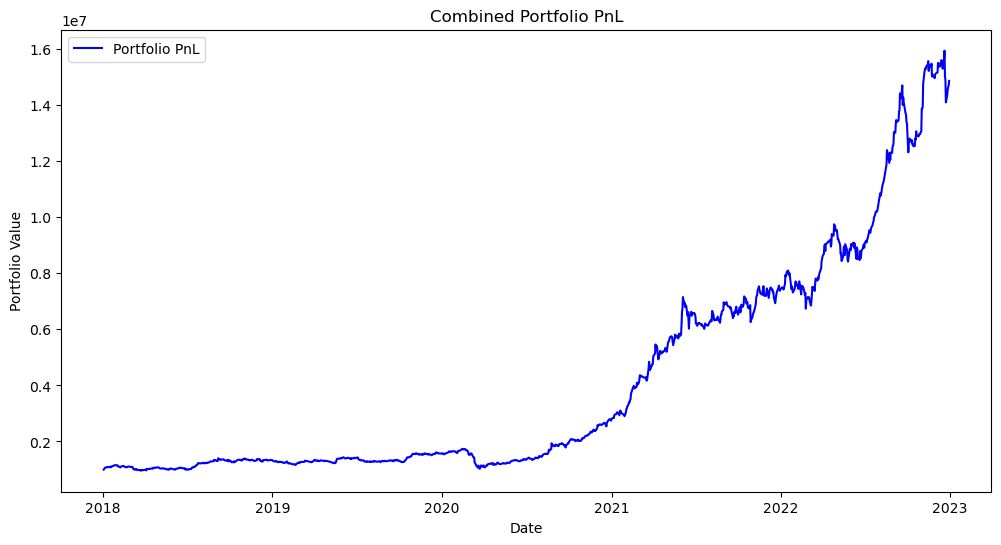

In [11]:
# Calculate the portfolio returns by multiplying the daily returns with weights
portfolio_returns = calculate_daily_returns(combined_returns.dot(weights))

# Calculate cumulative returns and portfolio value
cumulative_returns = (portfolio_returns + 1).cumprod()
portfolio_value = investment_amount * cumulative_returns

# Print Net Profit or Loss
print("Total Profit           : ", portfolio_value[-1]-investment_amount)
print("Total Profit%          : ", (portfolio_value[-1]-investment_amount)*100/investment_amount)

# Plot the combined PnL graph
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio PnL', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Combined Portfolio PnL')
plt.legend()
plt.show()

In [ ]:
# Currency and multiplier in PnL graph depends upon the user input